# House Price Index modelling with Linear Regression and XGBoost

### About the dataset

The data was compiled from different survey statistics obtained from https://fred.stlouisfed.org/. These include different variables which were outlined as significant during the research for initial MECE framework. They include different factors which affect the supply and demand for houses in USA including demographic and economic factors.

The S&P Case-Schiller Home Price Index is used as a proxy for home prices. Since this model is considering the United States of America as a whole rather than region specific, factors such as climate, location specific factors etc have not considered. 

In [288]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import math
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import PolynomialFeatures 
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

In [289]:
#reading the data
data=pd.read_csv("./USA HOUSING PRICES.CSV")

In [290]:
#taking a look at the dataset
data.head()

,Date,House Price Index,Real disposable personal income,Premium for Homeowner's Insurance Producer Index,Personal Saving Rate,New Houses Sold (in 1000s),New Houses for Sale (in 1000s),Monthly supply of new houses,"Expenditures: Maintenance, Repairs, Insurance, Other Expenses for Owned Dwelling",Expenditure: Mortage Interest,Expenditue: Property Tax,Employment Rate,Population(in 1000s),GDP,Homeownership Rate,Rent Index
0,2000-01-01,100.551,33119,105.9,5.0,873,311,4.3,103.75,333.916667,143.583333,81.724541,281083,101.488603,67.1,180.9
1,2000-02-01,101.339,33222,106.1,4.5,856,299,4.3,103.75,333.916667,143.583333,81.743599,281299,101.549520,67.1,181.3
2,2000-03-01,102.127,33284,106.3,4.3,900,313,4.3,103.75,333.916667,143.583333,81.721931,281531,101.623821,67.1,181.9
3,2000-04-01,102.922,33426,106.8,4.8,841,305,4.4,103.75,333.916667,143.583333,81.969054,281763,101.694923,67.3,182.3
4,2000-05-01,103.677,33537,107.3,4.8,857,305,4.4,103.75,333.916667,143.583333,81.588707,281996,101.736866,67.3,182.8


In [291]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 16 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Date                                                                              268 non-null    object 
 1   House Price Index                                                                 268 non-null    float64
 2   Real disposable personal income                                                   268 non-null    int64  
 3   Premium for Homeowner's Insurance Producer Index                                  268 non-null    float64
 4   Personal Saving Rate                                                              268 non-null    float64
 5   New Houses Sold (in 1000s)                                                        268 non-null    int64  
 6   Ne

Describing the different variables:

-> Date - First day of the month from 2000 onwards to latest available date

-> House Price Index - The S&P Case-Schiller Home Price Index is used as a proxy for home prices

-> Real Disposable Personal Income - (self explanatory)

-> Premium for Homeowner's Insurance Producer Index- The Index is used as a proxy for homeowner's insurance premium

-> Personal Saving Rate - Percentage of income that is saved 

-> New Houses Sold (in 1000s) - Total "new" houses sold per month in the 1000s

-> New Houses for Sale (in 1000s) - Total "new" houses for sale per month in the 1000s

-> Monthly Suppy of new houses- The months' supply is the ratio of new houses for sale to new houses sold. This statistic provides an indication of the size of the new for-sale inventory in relation to the number of new houses currently being sold. The months' supply indicates how long the current new for-sale inventory would last given the current sales rate if no additional new houses were built.

-> Expenditures: Maintenance, Repairs, Insurance, Other Expenses for Owned Dwelling - Monthly expenditure on the mentioned 

-> Expenditure: Mortage Interest - (self explanatory)

-> Expenditure: Property Tax - (self explanatory)

-> Employment Rate - Employment Rate: Aged 25-54: All Persons for the United States

-> Population(in 1000s) - Total Population in 1000s

-> GDP -  Leading Indicators OECD: Reference series: Gross Domestic Product (GDP): Normalised for the United States

->Homeownership Rate - The homeownership rate is the proportion of households that is owner-occupied.

->Rent Index - Rent of Primary Residence in U.S. Average Index



Since these variable names are quite long, renaming them for ease of coding

In [292]:
data.columns = ['date', 'price', 'income', 'insurance', 'sav_rate', 'houses_Sold', 'for_sale', 'house_supply', 
                'expenses', 'mortage', 'tax', 'emp_rate', 'popln', 'gdp', 'own_rate', 'rent']

In [293]:
data['date'] = pd.to_datetime(data['date'])

In [294]:

data.describe()

,price,income,insurance,sav_rate,houses_Sold,for_sale,house_supply,expenses,mortage,tax,emp_rate,popln,gdp,own_rate,rent
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,252.000000,252.000000,252.000000,268.000000,268.000000,266.000000,267.000000,268.000000
mean,168.030284,39569.257463,172.142784,6.623881,702.847015,313.212687,5.773134,160.357143,398.492064,222.908730,78.111096,310258.380597,99.882611,66.416854,260.632858
std,39.315269,4024.622579,33.060610,3.462289,291.901571,110.628014,1.877270,44.388318,40.395364,44.983138,2.022134,15982.110034,1.297800,1.818901,49.693909
min,100.551000,33119.000000,105.900000,2.100000,270.000000,142.000000,3.300000,103.750000,333.916667,143.583333,69.611723,281083.000000,91.542169,63.100000,180.900000
25%,141.662500,36615.000000,152.325000,5.000000,444.000000,226.750000,4.300000,135.333333,366.416667,189.583333,76.359129,296272.750000,99.533891,64.900000,218.000000
50%,164.310000,38685.000000,173.600000,6.400000,637.500000,305.500000,5.300000,143.250000,390.916667,228.083333,78.779325,311462.000000,99.936529,66.700000,251.710500
75%,184.538250,41860.000000,203.525000,7.400000,933.750000,371.250000,6.600000,190.750000,420.166667,254.500000,79.620137,325208.250000,100.532378,67.900000,299.330000
max,301.020000,57597.000000,217.803000,33.800000,1389.000000,572.000000,12.200000,272.250000,483.250000,296.916667,81.969054,332863.000000,101.825803,69.400000,363.067000


Since the different variables were extracted from different surveys, their availability is not uniform in terms of the timeline. This can be seen in the different count for each of the variables. 

Taking a look at the latest date for which all the variables are available

In [295]:
print(data.loc[[251]])

          date    price  income  insurance  sav_rate  houses_Sold  for_sale  \
251 2020-12-01  235.658   46371      215.2      14.0          871       300   

     house_supply  expenses  mortage         tax   emp_rate   popln  \
251           4.1    272.25    374.0  296.916667  76.312862  331968   

           gdp  own_rate     rent  
251  97.831934      65.7  344.078  


We can see that the latest date is December 2020 for which all the variables are available. Hence data is fully available from Jan 2000 to Dec 2020 - thus 21 years of data is available. 

Removing the tail end of the dataset for which there are null values.


In [296]:
data1 = data.dropna()
data1.describe()

,price,income,insurance,sav_rate,houses_Sold,for_sale,house_supply,expenses,mortage,tax,emp_rate,popln,gdp,own_rate,rent
count,252.000000,252.000000,252.000000,252.000000,252.00000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,161.661226,39060.761905,169.336508,6.382540,699.06746,309.960317,5.770238,160.357143,398.492064,222.908730,78.110673,308855.503968,99.905933,66.472619,254.836881
std,30.657420,3512.254956,32.096765,3.134872,300.07165,112.881520,1.917841,44.388318,40.395364,44.983138,2.064531,15446.898228,1.322002,1.857408,45.385409
min,100.551000,33119.000000,105.900000,2.100000,270.00000,142.000000,3.300000,103.750000,333.916667,143.583333,69.611723,281083.000000,91.542169,63.100000,180.900000
25%,140.312000,36454.250000,150.525000,4.900000,439.50000,217.000000,4.300000,135.333333,366.416667,189.583333,76.132450,295306.500000,99.569221,64.800000,215.850000
50%,161.967500,38490.000000,169.800000,6.300000,626.50000,301.000000,5.300000,143.250000,390.916667,228.083333,78.803621,309802.000000,99.956470,67.150000,249.370000
75%,183.025000,41509.500000,202.025000,7.300000,939.50000,350.750000,6.600000,190.750000,420.166667,254.500000,79.645963,322727.750000,100.559499,68.025000,288.597750
max,235.658000,51769.000000,215.200000,33.800000,1389.00000,572.000000,12.200000,272.250000,483.250000,296.916667,81.969054,331996.000000,101.825803,69.400000,344.078000


In [297]:
print('The total number of rows in the dataframe is:',len(data1))

The total number of rows in the dataframe is: 252


Creating new variables for month and year that can be used in modelling from the date variable.

In [298]:
data1['month'] = pd.DatetimeIndex(data1['date']).month
data1['year'] = pd.DatetimeIndex(data1['date']).year
data1['year']=data1['year']-2000
data1.head()


/var/folders/t6/dsxs7jxd3zb5l846bmwmm5w80000gn/T/ipykernel_12731/3260325006.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/t6/dsxs7jxd3zb5l846bmwmm5w80000gn/T/ipykernel_12731/3260325006.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/t6/dsxs7jxd3zb5l846bmwmm5w80000gn/T/ipykernel_12731/3260325006.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,date,price,income,insurance,sav_rate,houses_Sold,for_sale,house_supply,expenses,mortage,tax,emp_rate,popln,gdp,own_rate,rent,month,year
0,2000-01-01,100.551,33119,105.9,5.0,873,311,4.3,103.75,333.916667,143.583333,81.724541,281083,101.488603,67.1,180.9,1,0
1,2000-02-01,101.339,33222,106.1,4.5,856,299,4.3,103.75,333.916667,143.583333,81.743599,281299,101.549520,67.1,181.3,2,0
2,2000-03-01,102.127,33284,106.3,4.3,900,313,4.3,103.75,333.916667,143.583333,81.721931,281531,101.623821,67.1,181.9,3,0
3,2000-04-01,102.922,33426,106.8,4.8,841,305,4.4,103.75,333.916667,143.583333,81.969054,281763,101.694923,67.3,182.3,4,0
4,2000-05-01,103.677,33537,107.3,4.8,857,305,4.4,103.75,333.916667,143.583333,81.588707,281996,101.736866,67.3,182.8,5,0


Since the month is a cyclical variable, transforming it using trignometry to retain the cyclical nature. This is used instead of one hot encoding or making dummy variables out of the month variable.

In [299]:
max_value = data1["month"].max()
sin_values = [math.sin((2*(22/7)*x)/max_value) for x in list(data1["month"])]
cos_values = [math.cos((2*(22/7)*x)/max_value) for x in list(data1["month"])]
data1["month_sin"]= sin_values
data1["month_cosin"]= cos_values

/var/folders/t6/dsxs7jxd3zb5l846bmwmm5w80000gn/T/ipykernel_12731/611609864.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/t6/dsxs7jxd3zb5l846bmwmm5w80000gn/T/ipykernel_12731/611609864.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [300]:
data1 = data1.drop(['month'], axis=1)
data1 = data1.drop(['year'], axis=1)



Looking at the distributions of the different variables as well as visualizing the correlations between them



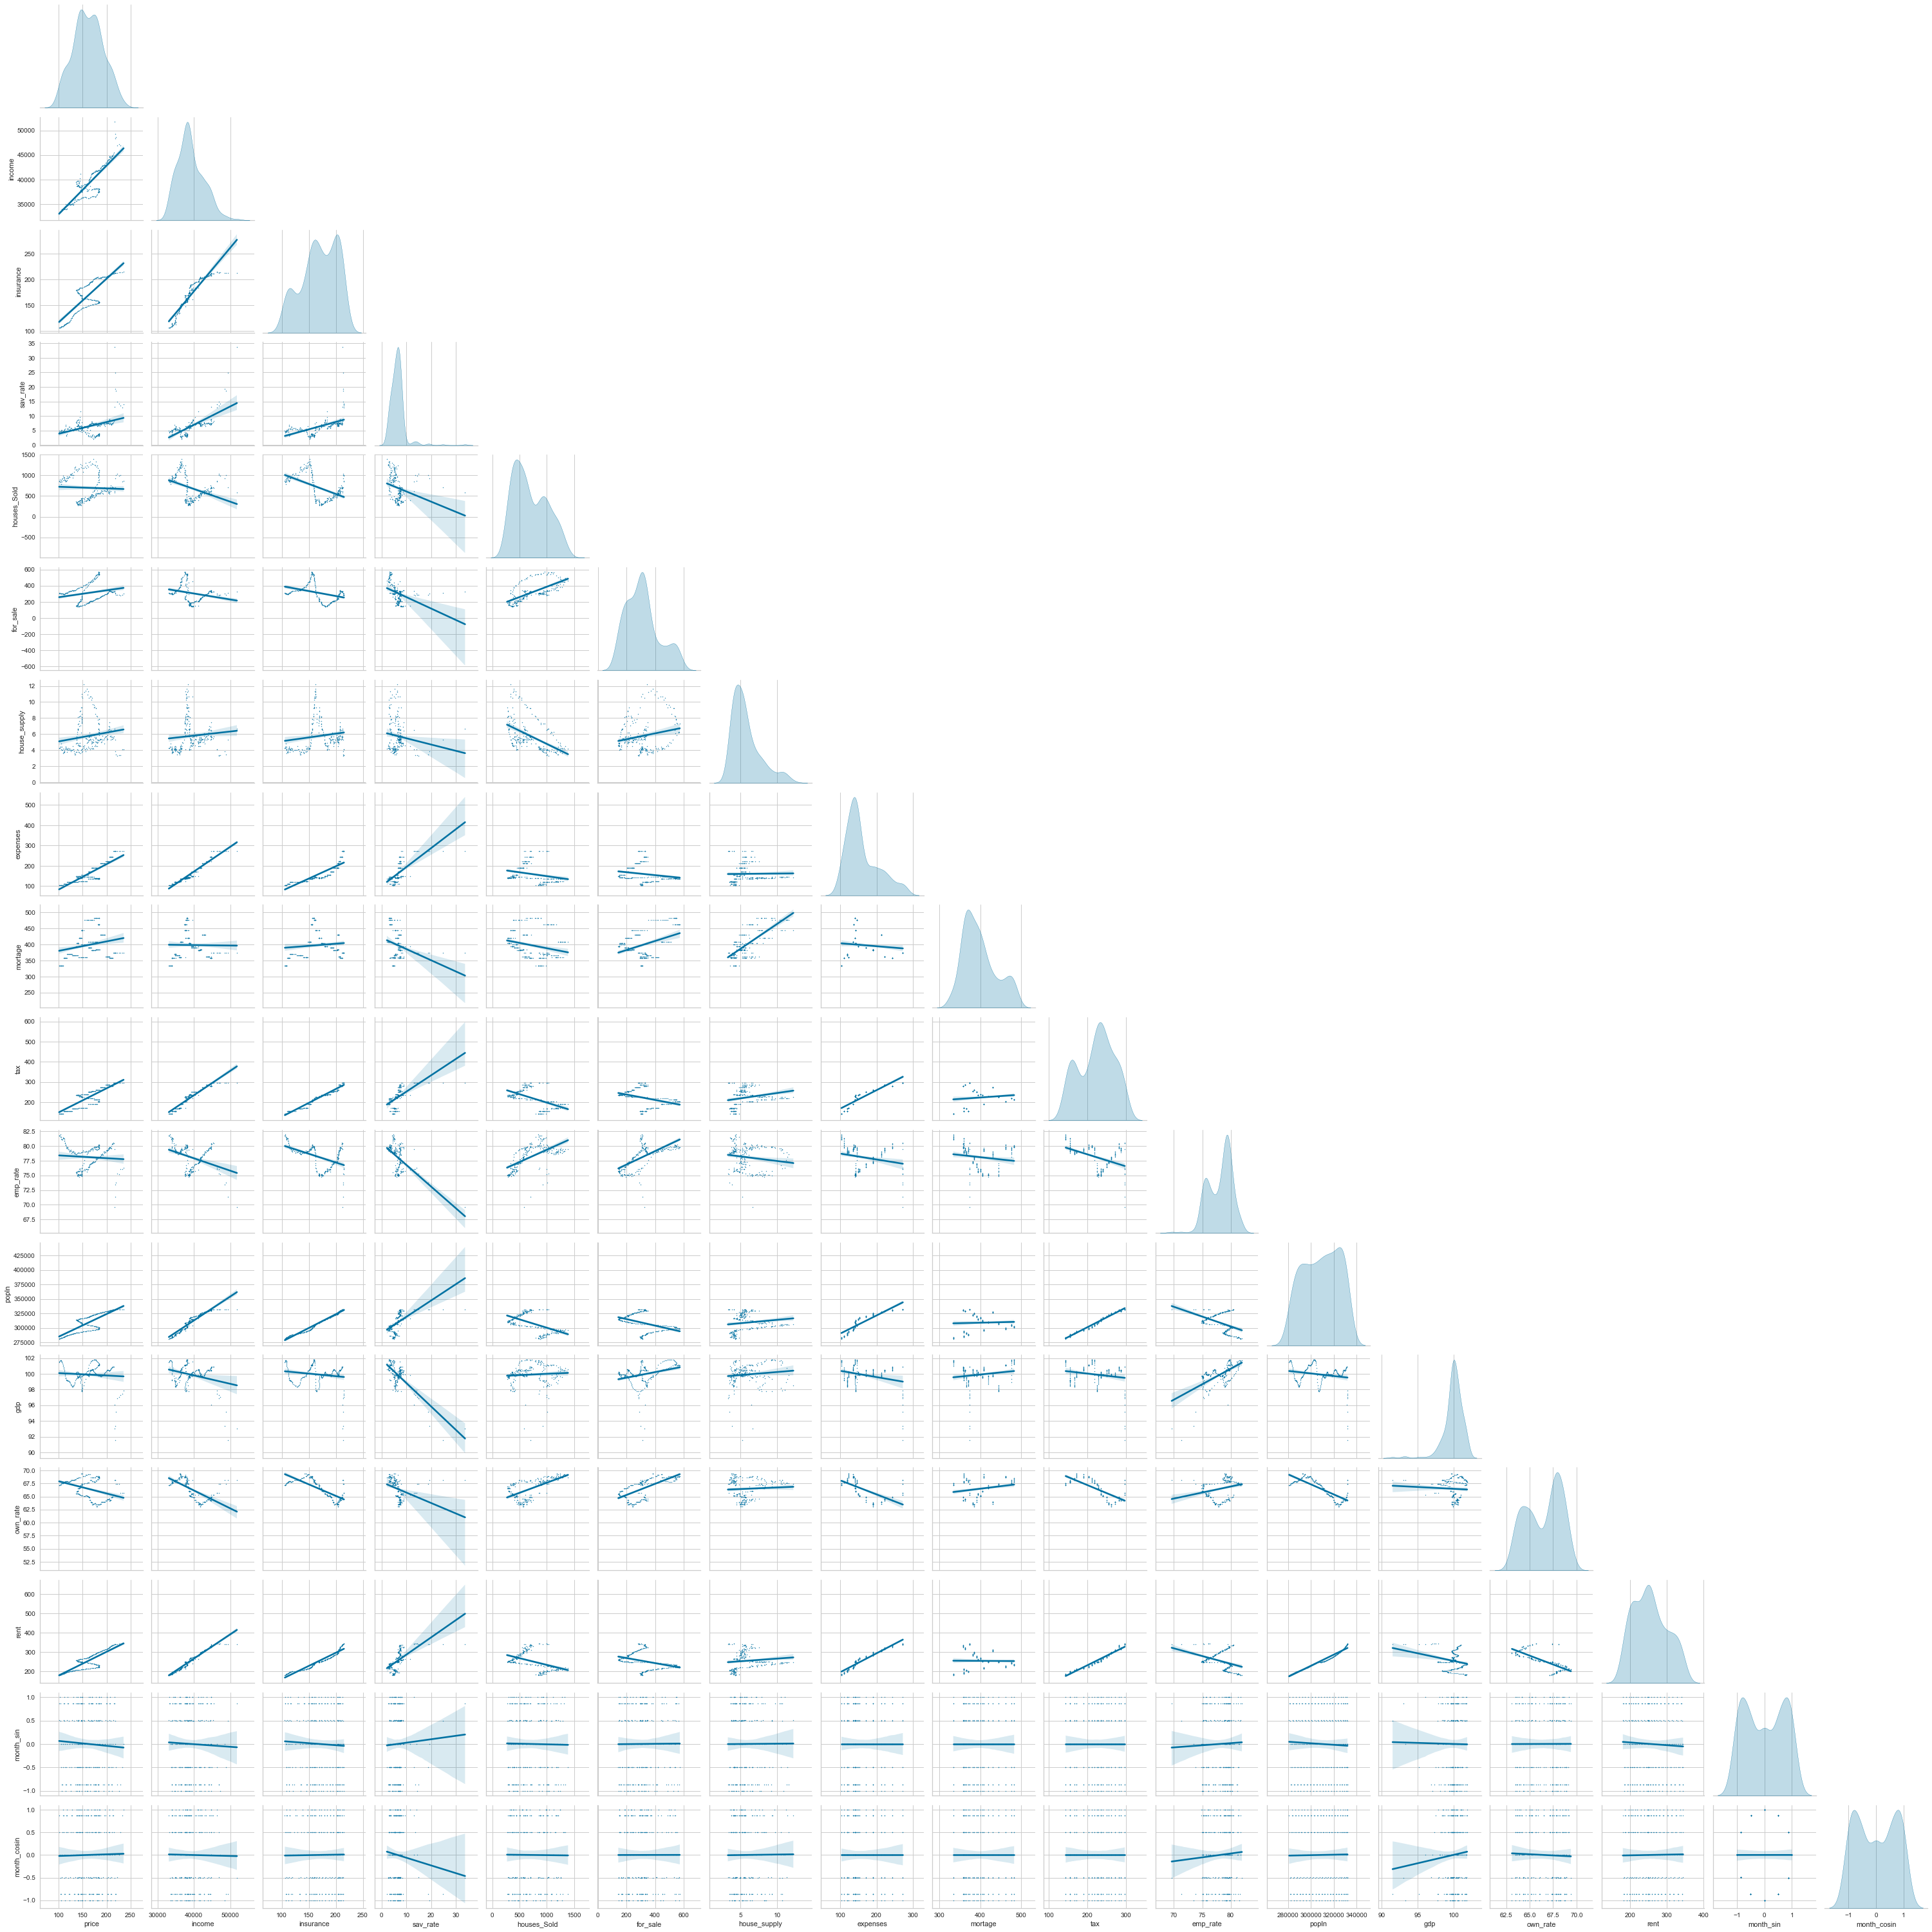

In [301]:
sns.pairplot(data1, corner=True, kind='reg', diag_kind='kde', plot_kws=dict(scatter_kws=dict(s=2)))

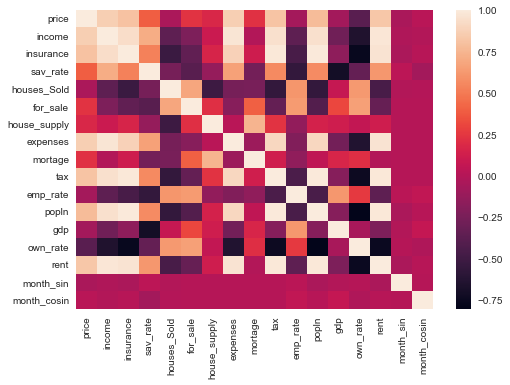

In [302]:
sns.heatmap(data1.corr());

In [303]:
data1.corr().price.sort_values(ascending = False)

price           1.000000
expenses        0.864376
income          0.861527
rent            0.827607
tax             0.810845
insurance       0.808030
popln           0.776034
sav_rate        0.392359
for_sale        0.231722
mortage         0.223710
house_supply    0.174870
month_cosin     0.015736
houses_Sold    -0.040696
month_sin      -0.044992
emp_rate       -0.070566
gdp            -0.071009
own_rate       -0.384955
Name: price, dtype: float64

From the table above, we can identify that expenses, income, rent, tax and expenditures are highly correlated to the price index. Now, the model will tell us how much of that is actually causal. 


Next we standardize the independent variables.

In [304]:
data1.iloc[:,2:] = data1.iloc[:,2:].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

Taking a look at how price index changes over time

In [305]:
import plotly.express as px
fig = px.line(data, x=data.date, y="price",)

fig.update_layout(
    template='gridon',
    title='Monthly House Price Index',
    xaxis_title='Year',
    yaxis_title='Price (£)',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

fig.show()

In [306]:
data1.set_index('date',inplace=True)
data1.index=pd.to_datetime(data1.index)

Taking a look at how trend and seasonality might affect price index

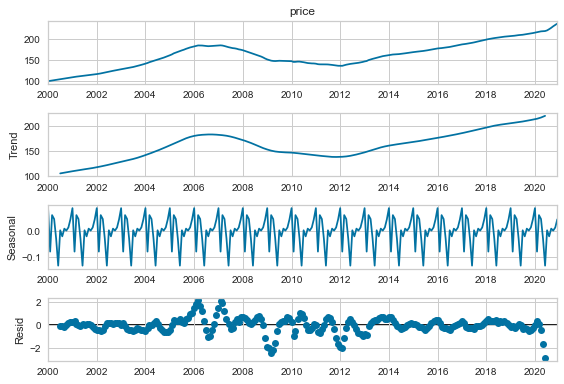

In [308]:
decomposition = sm.tsa.seasonal_decompose(data1['price'], model='additive')
fig = decomposition.plot()
plt.show()


Now to model the data, we first separate the independent variable and then create a test, training split.

In [407]:
X = data1.drop(['price'], axis=1)

y = data1['price']

In [441]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(f"No. of training examples: {X_train.shape[0]}")
print(f"No. of testing examples: {X_test.shape[0]}")



No. of training examples: 201
No. of testing examples: 51


Creating an XGBoost Model to better understand feature importance and how it affects the independent variable

In [409]:
xg_reg = xg.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.3,
                max_depth = 6, alpha = 10, n_estimators = 25,num_boost_round=60, nfold=4,early_stopping_rounds=10)


In [410]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)


[10:06:25] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sandeep/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [411]:
rmse = np.sqrt(MSE(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 3.493184


In [412]:
data_dmatrix = xg.DMatrix(data=X,label=y)

/Users/sandeep/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [413]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.3,
                'max_depth': 6, 'alpha': 10}
xg_reg = xg.train(params=params, dtrain=data_dmatrix,num_boost_round=60,)

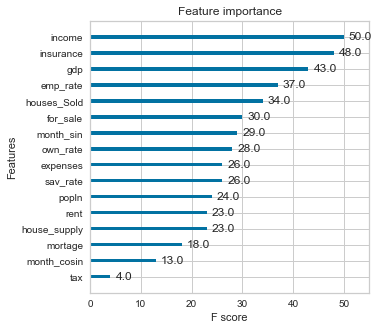

In [414]:
xg.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

According to XGBoost the most important features are: income, insurance, gdp and employment rate as well as houses for sale and houses sold.

Trying out the Linear Regression model as well as the regularization models, Lasso and Ridge.

In [444]:
#Fitting the linear regression model and making predictions
y_train1=StandardScaler().fit_transform(y_train.array.reshape(-1, 1))
y_test1=StandardScaler().fit_transform(y_test.array.reshape(-1, 1))
model1 = LinearRegression()
model1.fit(X_train, y_train1)
lr_preds = model1.predict(X_test)

#Assessing model performance
score1 = model1.score(X_test, y_test1)
mae = MAE(y_test1, lr_preds)
mse = MSE(y_test1, lr_preds)
rmse = np.sqrt(mse)
print(f'Mean squared error: {mse}')
print(f'Root mean squared error: {rmse}')

Mean squared error: 0.019412960157619424
Root mean squared error: 0.13933039925881008


Fitting ridge regression and making predictions


In [466]:
y_train2=StandardScaler().fit_transform(y_train.array.reshape(-1, 1))
y_test2=StandardScaler().fit_transform(y_test.array.reshape(-1, 1))
alph = [0.001, 0.01, 0.1]
score2,mae2,mse2,rmse2 =[],[],[],[]
for i in alph:
    model2 = Ridge(alpha = i)
    model2.fit(X_train, y_train2)
    preds2 = model2.predict(X_test)
    score2.append(model2.score(X_test,y_test2))
    mae2.append(MAE(y_test2, preds2))
    mse2.append(MSE(y_test2, preds2))
    rmse2.append(np.sqrt(MSE(y_test2, preds2)))


ridgepd= pd.DataFrame(list(zip(alph, score2, mae2, mse2, rmse2)),
                  columns=['alpha', 'Score', 'MAE', 'MSE', 'RMSE'])
rmse2 = ridgepd["RMSE"].max()
score2 =ridgepd["Score"].max()
ridgepd

,alpha,Score,MAE,MSE,RMSE
0,0.001,0.980578,0.101917,0.019422,0.139361
1,0.010,0.980505,0.101856,0.019495,0.139624
2,0.100,0.979985,0.101912,0.020015,0.141475


Fitting Lasso regression and making predictions after finding ideal alpha value

In [458]:
pipeline2 = Pipeline([('model',Lasso())])
y_train3=StandardScaler().fit_transform(y_train.array.reshape(-1, 1))
y_test3=StandardScaler().fit_transform(y_test.array.reshape(-1, 1))
model3 = GridSearchCV(pipeline2,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_root_mean_squared_error",verbose=3
                      )
model3.fit(X_train,y_train3)
preds3 = model3.predict(X_test)
score3 = model3.score(X_test, y_test3)
mae3 = MAE(y_test3, preds3)
mse3 = MSE(y_test3, preds3)
rmse3 = np.sqrt(mse3)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .................model__alpha=0.1;, score=-0.220 total time=   0.0s
[CV 2/5] END .................model__alpha=0.1;, score=-0.195 total time=   0.0s
[CV 3/5] END .................model__alpha=0.1;, score=-0.261 total time=   0.0s
[CV 4/5] END .................model__alpha=0.1;, score=-0.166 total time=   0.0s
[CV 5/5] END .................model__alpha=0.1;, score=-0.214 total time=   0.0s
[CV 1/5] END .................model__alpha=0.2;, score=-0.418 total time=   0.0s
[CV 2/5] END .................model__alpha=0.2;, score=-0.361 total time=   0.0s
[CV 3/5] END .................model__alpha=0.2;, score=-0.416 total time=   0.0s
[CV 4/5] END .................model__alpha=0.2;, score=-0.303 total time=   0.0s
[CV 5/5] END .................model__alpha=0.2;, score=-0.382 total time=   0.0s
[CV 1/5] END .model__alpha=0.30000000000000004;, score=-0.623 total time=   0.0s
[CV 2/5] END .model__alpha=0.30000000000000004;

In [459]:
print(f'Best alpha value: {model3.best_params_}')
print(f'Mean squared error: {mse3}')
print(f'Root mean squared error: {rmse3}')

Best alpha value: {'model__alpha': 0.1}
Mean squared error: 0.08417935042397959
Root mean squared error: 0.29013677881988625


In [460]:
coefficients = model3.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
print(importance)

[0.08019313 0.46055669 0.         0.         0.36748636 0.
 0.33650215 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [461]:
feature_names = list(X_train.columns.values)

In [462]:
np.array(feature_names)[importance > 0]

array(['income', 'insurance', 'for_sale', 'expenses'], dtype='<U12')

In [463]:
np.array(feature_names)[importance == 0]

array(['sav_rate', 'houses_Sold', 'house_supply', 'mortage', 'tax',
       'emp_rate', 'popln', 'gdp', 'own_rate', 'rent', 'month_sin',
       'month_cosin'], dtype='<U12')

Following Lasso, the following features have been discovered as significant: Income, Insurance, Houses for Sale and Expenses. 

Hence, this shows that we should look more into the exploratory data analysis to enable better feature engineering. This can also be improved with the help of a richer dataset.

In [467]:
print('Linear Regression Error: ', score1) 
print('Ridge Regression Error: ', score2)
print('Lasso Regression Error: ', score3)


Linear Regression Error:  0.9805870398423806
Ridge Regression Error:  0.9805784320051893
Lasso Regression Error:  -0.29013677881988625


Ridge regression scores best in terms of prediction, however,Linear Regression isnt too far behind. Lasso meanwhile scores the worst which might explain that removing features makes the model perform much worse.

In [476]:
from statsmodels.api import OLS
OLS(y_train1,X_train).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              2594.
Date:                Wed, 06 Jul 2022   Prob (F-statistic):                   3.46e-208
Time:                        10:26:30   Log-Likelihood:                          259.26
No. Observations:                 201   AIC:                                     -486.5
Df Residuals:                     185   BIC:                                     -433.7
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
income          -0.2885      0.087     -3.333      0.001      -0.459      -0.118
insurance        0.2702      0.104      2.588      0.010       0.064       0.476
sav_rate         0.0471      0.028      1.671      0.096      -0.009       0.103
houses_Sold      0.1897      0.036      5.273      0.000       0.119       0.261
for_sale         0.5381      0.028     19.020      0.000       0.482       0.594
house_supply    -0.0286      0.019     -1.489      0.138      -0.066       0.009
expenses         0.1472      0.056      2.641      0.009       0.037       0.257
mortage          0.0097      0.013      0.775      0.440      -0.015       0.035
tax              0.2649      0.063      4.177      0.000       0.140       0.390
emp_rate        -0.1091      0.025     -4.312      0.000      -0.159      -0.059
popln            0.1729      0.245      0.705      0.482      -0.311       0.657
gdp              0.0495      0.015      3.210      0.002       0.019       0.080
own_rate         0.0094      0.024      0.389      0.698      -0.038       0.057
rent             0.4782      0.172      2.782      0.006       0.139       0.817
month_sin       -0.0172      0.006     -3.003      0.003      -0.028      -0.006
month_cosin      0.0085      0.005      1.687      0.093      -0.001       0.018
==============================================================================
Omnibus:                       35.970   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.929
Skew:                           0.710   Prob(JB):                     6.04e-24
Kurtosis:                       6.279   Cond. No.                         168.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [432]:
from statsmodels.tools.tools import pinv_extended
import statsmodels.api as sm
import sklearn, statsmodels

def regression_analysis(X, y, model):
    
    is_statsmodels = False
    is_sklearn = False
    
    # check for accepted linear models
    if type(model) in [sklearn.linear_model._base.LinearRegression,
                       sklearn.linear_model._ridge.Ridge,
                       sklearn.linear_model._ridge.RidgeCV,
                       sklearn.linear_model._coordinate_descent.Lasso,
                       sklearn.linear_model._coordinate_descent.LassoCV,
                       sklearn.linear_model._coordinate_descent.ElasticNet,
                       sklearn.linear_model._coordinate_descent.ElasticNetCV,
                      ]:
        is_sklearn = True
    elif type(model) in [statsmodels.regression.linear_model.OLS, 
                         statsmodels.base.elastic_net.RegularizedResults,
                        ]:
        is_statsmodels = True
    else:
        print("Only linear models are supported!")
        return None
    
    
    
    has_intercept = False
    
    if is_statsmodels and all(np.array(X)[:,0]==1):
        # statsmodels add_constant has been used already
        has_intercept = True  
    elif is_sklearn and model.intercept_:
        has_intercept = True
        

    
    if is_statsmodels:
        # add_constant has been used already
        x = X
        model_params = model.params
    else: # sklearn model
        if has_intercept:
            x = sm.add_constant(X)
            model_params = np.hstack([np.array([model.intercept_]), model.coef_])
        else:
            x = X
            model_params = model.coef_
        
    #y = np.array(y).ravel()
    
    # define the OLS model
    olsModel = sm.OLS(y, x)
    
    pinv_wexog,_ = pinv_extended(x)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    
    
    return sm.regression.linear_model.OLSResults(olsModel, model_params, normalized_cov_params)
    

In [529]:
from sklearn.linear_model import Ridge

k=y_train1.flatten()
skridge = Ridge(alpha=0.001, max_iter=9000, tol=1e-5, fit_intercept=True)
skridge.fit(X_train,k)

result = regression_analysis(X_train,k, skridge)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2585.
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          4.21e-207
Time:                        10:45:52   Log-Likelihood:                 259.45
No. Observations:                 201   AIC:                            -484.9
Df Residuals:                     184   BIC:                            -428.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0029      0.005      0.594      0.553      -0.007       0.013
income          -0.2861      0.087     -3.299      0.001      -0.457      -0.115
insurance        0.2737      0.105      2.611      0.010       0.067       0.480
sav_rate         0.0462      0.028      1.634      0.104      -0.010       0.102
houses_Sold      0.1890      0.036      5.242      0.000       0.118       0.260
for_sale         0.5378      0.028     18.976      0.000       0.482       0.594
house_supply    -0.0285      0.019     -1.484      0.140      -0.066       0.009
expenses         0.1493      0.056      2.670      0.008       0.039       0.260
mortage          0.0097      0.013      0.767      0.444      -0.015       0.035
tax              0.2643      0.064      4.161      0.000       0.139       0.390
emp_rate        -0.1097      0.025     -4.323      0.000      -0.160      -0.060
popln            0.1667      0.246      0.677      0.499      -0.319       0.652
gdp              0.0494      0.015      3.203      0.002       0.019       0.080
own_rate         0.0087      0.024      0.359      0.720      -0.039       0.057
rent             0.4767      0.172      2.768      0.006       0.137       0.816
month_sin       -0.0172      0.006     -2.993      0.003      -0.028      -0.006
month_cosin      0.0085      0.005      1.690      0.093      -0.001       0.018
==============================================================================
Omnibus:                       35.684   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.593
Skew:                           0.705   Prob(JB):                     1.18e-23
Kurtosis:                       6.258   Cond. No.                         168.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [530]:
k=y_train1.flatten()
sklasso = Lasso(alpha=0.1, max_iter=9000, tol=1e-5, fit_intercept=True)
sklasso.fit(X_train,k)

result = regression_analysis(X_train, k, sklasso)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     263.0
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          1.94e-117
Time:                        10:46:20   Log-Likelihood:                 33.626
No. Observations:                 201   AIC:                            -33.25
Df Residuals:                     184   BIC:                             22.90
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0071      0.015      0.469      0.639      -0.023       0.037
income           0.0793      0.267      0.297      0.767      -0.447       0.606
insurance        0.4608      0.322      1.430      0.155      -0.175       1.097
sav_rate              0      0.087          0      1.000      -0.172       0.172
houses_Sold           0      0.111          0      1.000      -0.219       0.219
for_sale         0.3675      0.087      4.216      0.000       0.196       0.539
house_supply          0      0.059          0      1.000      -0.117       0.117
expenses         0.3372      0.172      1.961      0.051      -0.002       0.676
mortage               0      0.039          0      1.000      -0.076       0.076
tax                   0      0.195          0      1.000      -0.386       0.386
emp_rate              0      0.078          0      1.000      -0.154       0.154
popln                 0      0.757          0      1.000      -1.493       1.493
gdp                   0      0.047          0      1.000      -0.094       0.094
own_rate             -0      0.075         -0      1.000      -0.148       0.148
rent                  0      0.530          0      1.000      -1.045       1.045
month_sin            -0      0.018         -0      1.000      -0.035       0.035
month_cosin           0      0.015          0      1.000      -0.031       0.031
==============================================================================
Omnibus:                        3.039   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                2.802
Skew:                           0.287   Prob(JB):                        0.246
Kurtosis:                       3.063   Cond. No.                         168.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""